In [ ]:
## ***
## NOTE: edit default_device() in common/torch/ops.py for your gpu
## ***
###

## versions:
## Python    : 3.11.5
## numpy     : 1.26.0
## torch     : 2.1.0
## pandas    : 2.1.1

# licensed under the Creative Commons - Attribution-NonCommercial 4.0
# International license (CC BY-NC 4.0):
# https://creativecommons.org/licenses/by-nc/4.0/. 

In [1]:
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt
import os

from common.torch.snapshots import SnapshotManager

from covid_hub.data_utils import download_training_data
from covid_hub.forecast import Struct, default_settings, load_training, normalize_training, make_training_fn
from covid_hub.forecast import ensemble_loop, generate_quantiles, output_figs, output_csv

In [ ]:
## get the latest training data
#download_training_data()

In [ ]:
## delete saved models
#try:
#    shutil.rmtree("hub_model_snapshots")
#except:
#    pass


In [2]:
settings = default_settings()
settings

iterations: 400
init_LR: 0.00025
batch_size: 256
lookback_opts: [3, 4, 4, 5, 5, 6, 7]
use_cat_opts: [False]
horizon: 40
data_suffix: 3ma
targ_var: h
lfn_name: t_nll
force_positive_forecast: False
normalize_target: False
use_windowed_norm: True
exog_vars: ['doy', 'dewpC', 'vacc_rate']
nbeats_stacks: 12
nbeats_hidden_dim: 512
nbeats_dropout: 0.2
encoder_k: 4
encoder_hidden_dim: 128
encoder_dropout: 0.2
variance_scale: 1.0
data_is_log: False
qtiles: [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99]

In [5]:

test_cut_vals = [1264, 1208, 1152, 1145, 1096] + [950, 908, 901, 740, 733, 642]
forecast_delay_days = [10, 10, 10, 10, 10] + [2, 2, 2, 2, 2, 2]


In [5]:

settings.lookback_opts = [3,4,4,5,5,6,7]#[3,3,4,4,5,5,6,6,7,7]#  ## backward window size, in horizons
settings.nbeats_stacks=12 #8 # more data can support deeper model
settings.exog_vars = ["doy","t_decay","dewpC","vacc_rate"]

test_cut_vals = [1264]
forecast_delay_days = [10]


In [6]:

settings.lookback_opts = [3,3,4,4,5,5]
settings.nbeats_stacks=8
settings.exog_vars = ["doy","t_decay","dewpC","vacc_rate"]

test_cut_vals = [908, 901, 740, 733, 642]
forecast_delay_days = [2, 2, 2, 2, 2]

In [ ]:

for (cut,forecast_delay) in zip(test_cut_vals, forecast_delay_days):

    ## if using mac metal:
    t.mps.empty_cache()
    ## clean state for current run:
    rstate = Struct()

    load_training(rstate, settings, cut)
    normalize_training(rstate, settings)

    ## create training function
    rstate.training_fn = make_training_fn(training_data = rstate.vals_train,
                            static_categories = rstate.static_cat,
                            target_key = rstate.target_key,
                            horizon = settings.horizon,
                            windowed_norm = settings.use_windowed_norm,
                            init_LR = settings.init_LR,
                            batch_size = settings.batch_size)

    ensemble_loop(rstate, settings)
    generate_quantiles(rstate, settings)
    output_figs(rstate, settings)
    output_csv(rstate, settings, forecast_delay)


In [ ]:
#f = "https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Hospitalizations.csv"
#df = pd.read_csv(f,dtype={"location":str})
#d_str = pd.to_datetime(df.date).max().strftime("%m-%d")
#df.to_csv("storage/truth-inc-hosp-" + d_str + ".csv", index=False)

In [3]:
cut = 1271
forecast_delay = 10


In [4]:
t.mps.empty_cache()
rstate = Struct()

load_training(rstate, settings, cut)

In [5]:
normalize_training(rstate, settings)

In [6]:
rstate.training_fn = make_training_fn(training_data = rstate.vals_train,
                        static_categories = rstate.static_cat,
                        target_key = rstate.target_key,
                        horizon = settings.horizon,
                        windowed_norm = settings.use_windowed_norm,
                        init_LR = settings.init_LR,
                        batch_size = settings.batch_size)


In [7]:
ensemble_loop(rstate, settings)

training  t_nll_0_0_1271


/Users/sasha/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/Users/sasha/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:26: UserWarning: The operator 'aten::_weight_norm_interface' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391829313/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return _weight_norm(v, g, self.dim)
/Users/sasha/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.war

training  t_nll_1_0_1271
training  t_nll_2_0_1271
training  t_nll_3_0_1271
training  t_nll_4_0_1271
training  t_nll_5_0_1271
training  t_nll_6_0_1271


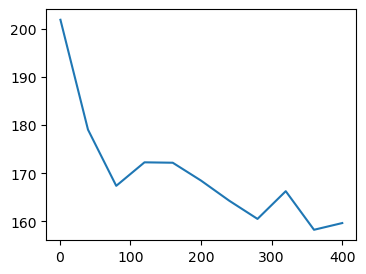

In [8]:
snapshot_manager = SnapshotManager(snapshot_dir=os.path.join('hub_model_snapshots', [k for k in rstate.mu_fc][2]), total_iterations=settings.iterations)

ldf = snapshot_manager.load_training_losses()
_, ax = plt.subplots(figsize=[4,3])
ax.plot(ldf)
plt.show()

In [9]:
generate_quantiles(rstate, settings)

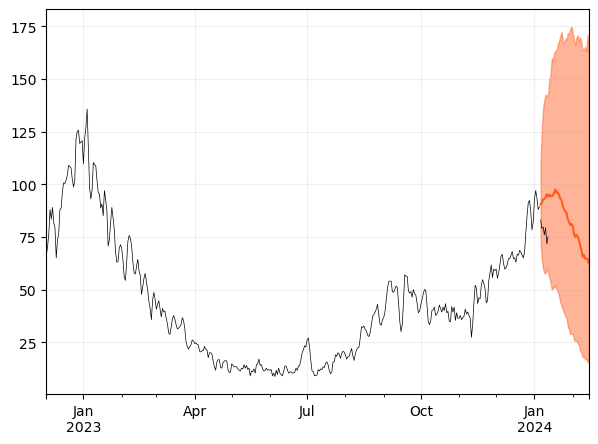

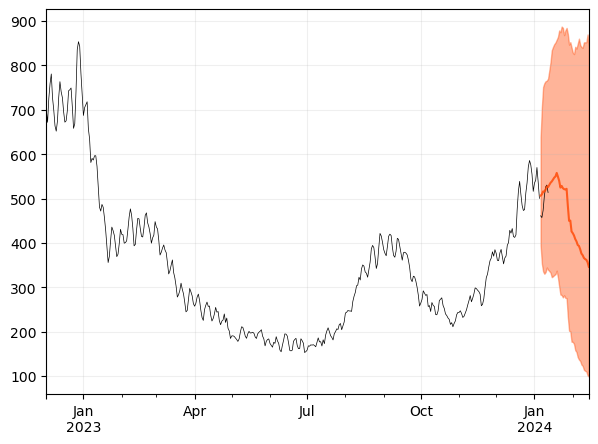

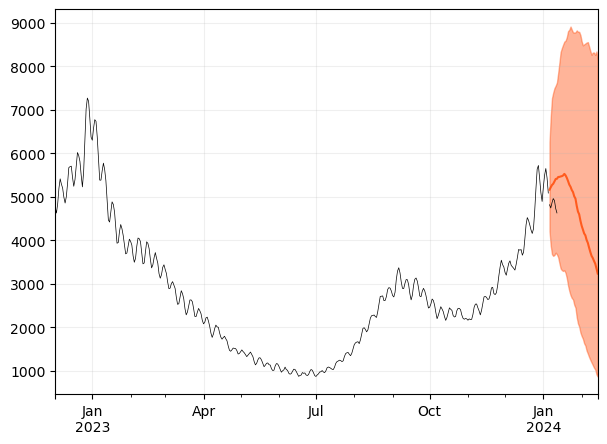

In [10]:
output_figs(rstate, settings)


In [18]:
output_csv(rstate, settings, forecast_delay)


writing  storage/2024-01-15-OHT_JHU-nbxd.csv
